<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Computer-Vision-Projects/blob/main/Pneumonia_Classification_using_CNN_on_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification using CNN on Chest X-ray dataset with Tensorflow

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 18/06/2024

**Reference:** [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](https://doi.org/10.1016/j.cell.2018.02.010)



## Introduction

This CNN Model will predict whether an X-ray scan shows presence of pneumonia or not.

## Setup

In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
  print('Device:', tpu.master())
  strategy = tf.distribute.TPUStrategy(tpu)
except:
  strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Configuration parameters

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

## Load the data

### Load and format the train data

In [3]:
## Load Chest X-ray data
train_images = tf.data.TFRecordDataset(
    'gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec'
)
train_paths = tf.data.TFRecordDataset(
    'gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec'
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [4]:
## Let's count No of healthy/normal chest X-rays
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if 'NORMAL' in filename.numpy().decode('utf-8')
    ]
)
print('Normal images count in training set: ' + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if 'PNEUMONIA' in filename.numpy().decode('utf-8')
    ]
)
print('Pneumonia images count in training set: ' + str(COUNT_PNEUMONIA))


Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [7]:
## Mapping each filename to the corresponding (image, label) pair

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  if parts[-2] == 'PNEUMONIA':
    return 1
  else:
    return 0

def decode_img(img):
  # Convert the compressed string to a 3D unit8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(image, path):
  label = get_label(path)
  # load the raw data from the file as a string
  img = decode_img(image)
  return img, label

ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
## Split the data into a training and validation datasets
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [12]:
## visualize the shape of an (image, label) pair
for image, label in train_ds.take(1):
  print('Image Shape:', image.numpy().shape)
  print('Label:', label.numpy())

Image Shape: (180, 180, 3)
Label: 1


### Load and format the test data

In [13]:
test_images = tf.data.TFRecordDataset(
    'gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec'
)
test_paths = tf.data.TFRecordDataset(
    'gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec'
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## Visualize the dataset

In [15]:
def prepare_for_training(ds, cache=True):
  '''
  This is a small dataset, only load it once, and keep it in memory.
  use `.cache(filename)` to cache preprocessing work for datasets that don't
  fit in memory.
  '''
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.batch(BATCH_SIZE)

  '''
  `prefetch` lets the dataset fetch batches in the background
  while the model is training.
  '''
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [16]:
## Call the next batch iteration of the training data
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [17]:
## Define the method to show the images in the batch
def show_batch(image_size, label_batch):
  plt.figure(figsize=(10, 10))
  for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n] / 255)
    if label_batch[n]:
      plt.title('PNEUMONIA')
    else:
      plt.title('NORMAL')
    plt.axis('off')

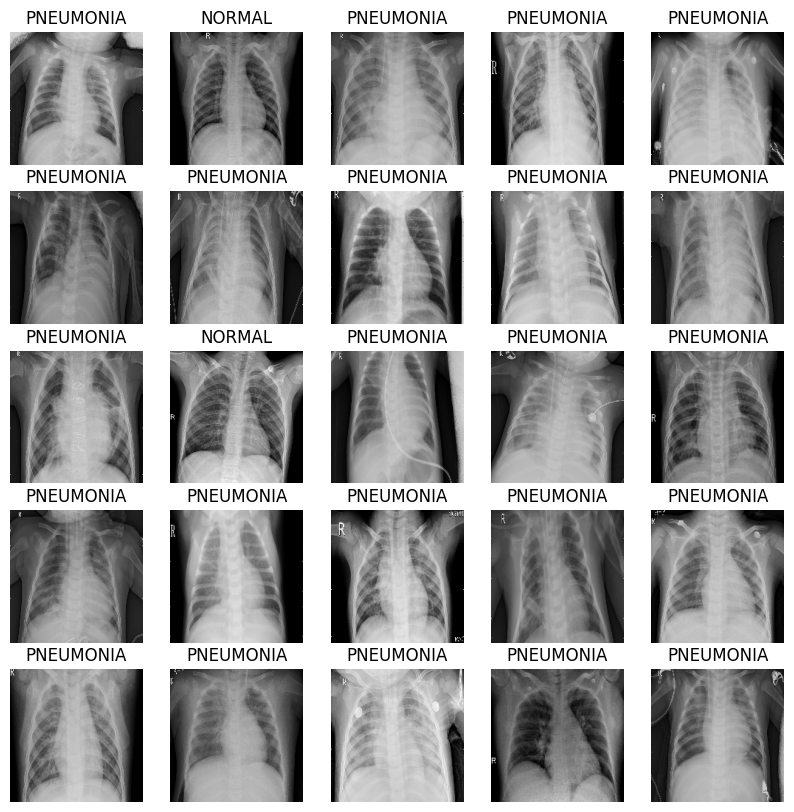

In [18]:
## Visualize the data
show_batch(image_batch.numpy(), label_batch.numpy())

## Building the CNN Model

![](https://miro.medium.com/v2/resize:fit:1400/1*7_BCJFzekmPXmJQVRdDgwg.png)

In [35]:
## Desine the Model blocks
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import layers

def conv_block(filters, inputs):
  x = layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(inputs)
  x = layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  outputs = layers.MaxPool2D()(x)

  return outputs

def dense_block(units, dropout_rate, inputs):
  x = layers.Dense(units, activation='relu')(inputs)
  x = layers.BatchNormalization()(x)
  outputs = layers.Dropout(dropout_rate)(x)

  return outputs

In [36]:
## Build the CNN model function
def build_model():
  inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
  x = layers.MaxPool2D()(x)

  x = conv_block(32, x)
  x = conv_block(64, x)

  x = conv_block(128, x)
  x = layers.Dropout(0.2)(x)

  x = conv_block(256, x)
  x = layers.Dropout(0.2)(x)

  x = layers.Flatten()(x)
  x = dense_block(512, 0.7, x)
  x = dense_block(128, 0.5, x)
  x = dense_block(64, 0.3, x)

  outputs = layers.Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

## Correct for data imbalance

More images classified as pneumonia than normal.
- Normal images count in training set: 1349
- Pneumonia images count in training set: 3883



In [37]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print('Initial bias: {:.5f}'.format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('weight for class 0: {:.2f}'.format(weight_for_0))
print('weight for class 1: {:.2f}'.format(weight_for_1))

Initial bias: 1.05724
weight for class 0: 1.94
weight for class 1: 0.67


## Train the model

### Defining callbacks

- The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it.

- The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting.

In [38]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('xray_model.keras',
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

We also want to tune our learning rate.

- Too high of a learning rate will cause the model to diverge.
- Too small of a learning rate will cause the model to be too slow.

In [39]:
## Implementing the exponential learning rate scheduling
initial_learning_rate = 0.015
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

### Fit the model

In [52]:
with strategy.scope():
  model = build_model()

  METRICS = [
      keras.metrics.BinaryAccuracy(),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
  ]
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
      loss='binary_crossentropy',
      metrics=METRICS,
  )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
168/168 [==============================] - 47s 254ms/step - loss: 0.4174 - binary_accuracy: 0.8131 - precision: 0.9271 - recall: 0.8121 - val_loss: 0.7259 - val_binary_accuracy: 0.7781 - val_precision: 0.7795 - val_recall: 0.9819
Epoch 2/100
168/168 [==============================] - 41s 242ms/step - loss: 0.2762 - binary_accuracy: 0.8898 - precision: 0.9592 - recall: 0.8894 - val_loss: 4.0344 - val_binary_accuracy: 0.3159 - val_precision: 1.0000 - val_recall: 0.0879
Epoch 3/100
168/168 [==============================] - 41s 243ms/step - loss: 0.2438 - binary_accuracy: 0.9014 - precision: 0.9652 - recall: 0.8996 - val_loss: 1.2709 - val_binary_accuracy: 0.6870 - val_precision: 1.0000 - val_recall: 0.5827
Epoch 4/100
168/168 [==============================] - 41s 246ms/step - loss: 0.1949 - binary_accuracy: 0.9231 - precision: 0.9745 - recall: 0.9205 - val_loss: 0.8088 - val_binary_accuracy: 0.7655 - val_precision: 0.7618 - val_recall: 1.0000
Epoch 5/100
168/168 [===========

## Visualizing model performance

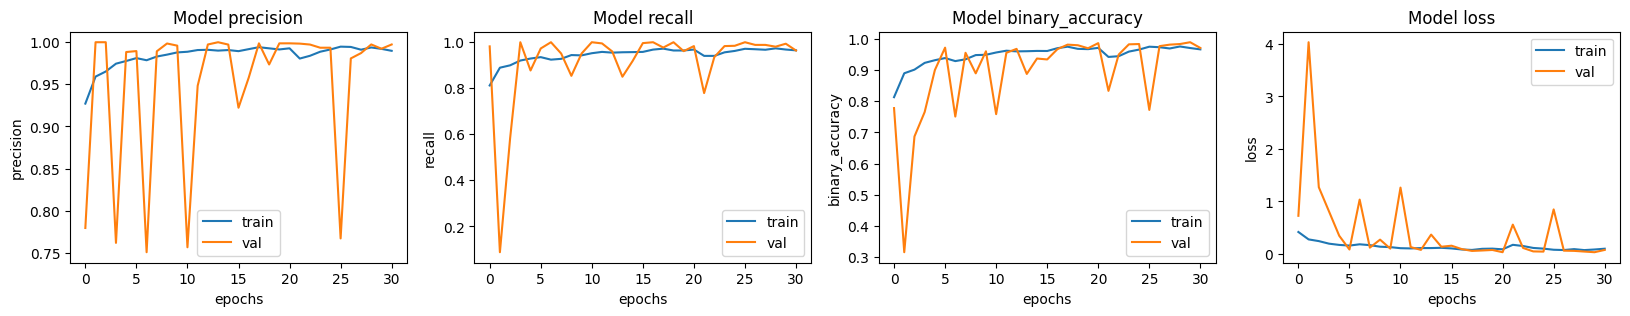

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'binary_accuracy', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_' + met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])

## Predict and evaluate results

In [54]:
model.evaluate(test_ds, return_dict=True)

25/25 [==============================] - 6s 32ms/step - loss: 1.3688 - binary_accuracy: 0.8173 - precision: 0.7805 - recall: 0.9846


{'loss': 1.3687824010849,
 'binary_accuracy': 0.817307710647583,
 'precision': 0.7804877758026123,
 'recall': 0.9846153855323792}

- We see that our accuracy on our test data is lower than the accuracy for our validating set. This may indicate overfitting.
- Our recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified. We should aim to increase our precision.

## Inference on test data

1/1 [==============================] - 0s 261ms/step
This image is 85.45 percent NORMAL
This image is 14.55 percent PNEUMONIA


<ipython-input-57-79d988feac84>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('This image is %.2f percent %s'% ((100 * score), name))


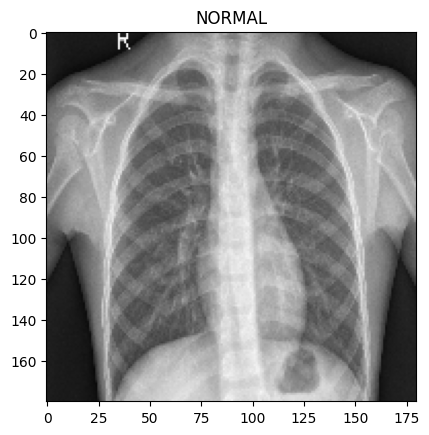

In [57]:
for image, label in test_ds.take(1):
  plt.imshow(image[0] / 255.0)
  plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
  print('This image is %.2f percent %s'% ((100 * score), name))